In [1]:
import numpy as np
import pandas as pd

import anisotropy.materials as materials
import anisotropy.effective_modelling.n_layers as n_layers

In [2]:
kkm_results = pd.read_csv("../data/splitting_results/kkm_results.txt", delim_whitespace=True)

# kkm_results = kkm_results[(kkm_results["category"] != "poor") & (kkm_results["category"] != "null-measurement")]
kkm_results = kkm_results[kkm_results["category"] == "good"]
kkm_results_tmp = pd.DataFrame()
kkm_results_tmp["Baz."] = kkm_results["baz"].values
kkm_results_tmp["PHI"] = kkm_results["phi"].values
kkm_results_tmp["DPHI"] = np.ones(len(kkm_results))*10
kkm_results_tmp["TLAG"] = kkm_results["delta"].values
kkm_results_tmp["DTLAG"] = np.ones(len(kkm_results))*0.25

kkm_results = kkm_results_tmp

In [3]:
angle_of_incidence = 11.2262

olivine = materials.load("olivine")
olivine = olivine.rotate(90, 0, 0)

# Define layer 1
layer1 = n_layers.ElasticLayer(olivine, thickness=150, ψ_a=58, fractional_alignment=0.3888)

# Define layer 2
layer2 = n_layers.ElasticLayer(olivine, thickness=25, ψ_a=-12, fractional_alignment=0.3888)

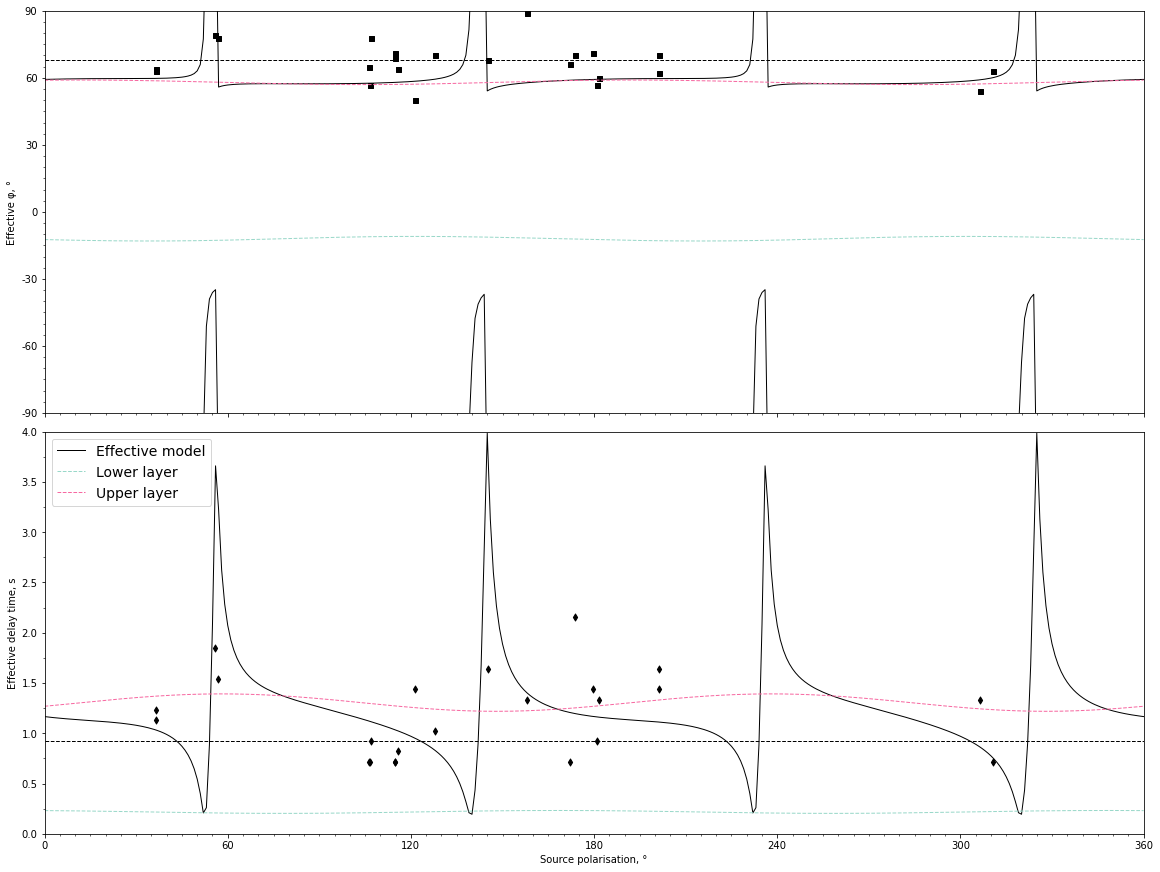

In [4]:
# Calculate the effective splitting and plot
layers = [layer2, layer1]
effective_results = n_layers.model(0.125, layers, angle_of_incidence)

n_layers.plot_effective_splitting(*effective_results, layers, angle_of_incidence, observations=kkm_results, fixed_model=(68, 0.92), filename="figureS5.pdf")

In [9]:
def _calculate_misfit(observations, layers, angle_of_incidence):
    """
    Calculate the misfit between measured values of (φ, δt) and a trial N layer
    model. This is based on the equations set out in:

        Liddell, M.V., Bastow, I., Darbyshire, F., Gilligan, A. and Pugh, S.,
        2017. The formation of Laurentia: Evidence from shear wave splitting.
        Earth and Planetary Science Letters, 479, pp.170-178.

        Merry, T.A., Bastow, I.D., Kounoudis, R., Ogden, C.S., Bell, R.E. and
        Jones, L., 2021. The influence of the North Anatolian Fault and a
        fragmenting slab architecture on upper mantle seismic anisotropy in the
        eastern Mediterranean. Geochemistry, Geophysics, Geosystems, 22(9),
        p.e2021GC009896.

    Parameters
    ----------
    observations : pandas.DataFrame object
        This should either be a DataFrame or perhaps a custom data format
        develop as part of the overall package. This would mean that results
        generated with other splitting codes could be used by simply writing
        a parser that converts the outputs of the external codes into the
        custom data file format.
    layers : list of `anisotropy.ElasticLayer` object
        Layers in the model.
    angle_of_incidence : float
        Angle of incidence of a ray with the surface, relative to vertical, in
        degrees.

    Returns
    -------
    M : float
        Calculated misfit for the set of measurements and the given model.

    """

    φφ, δδt, dφφ, dδδt, backazimuths = observations
    Γφ, Γδt = [], []
    for φ, δt, dφ, dδt, backazimuth in zip(φφ, δδt, dφφ, dδδt, backazimuths):
        azimuths = np.arange(backazimuth-5, backazimuth+6, 1)
        effective_results = n_layers.model(0.125, layers, angle_of_incidence, azimuths)
        effective_φφ, effective_δδt = effective_results

        Γφx = np.array([abs(φ - effective_φ) - dφ
                        for effective_φ in effective_φφ])
        Γφx[Γφx < 0] = 0
        Γφ.append(min(Γφx))

        Γδtx = np.array([abs(δt - effective_δt) - dδt
                         for effective_δt in effective_δδt])
        Γδtx[Γδtx < 0] = 0
        Γδt.append(min(Γδtx))

    rms_φ = np.sqrt(np.mean([Γφ_i**2 for Γφ_i in Γφ]))
    rms_δt = np.sqrt(np.mean([Γδt_i**2 for Γδt_i in Γδt]))
    print(rms_φ, rms_δt)

    M = rms_φ/np.std(φφ) + rms_δt/np.std(δδt)

    return M

In [12]:
def _calculate_misfit_1layer(observations, layer, angle_of_incidence):
    """
    Calculate the misfit between measured values of (φ, δt) and a trial N layer
    model. This is based on the equations set out in:

        Liddell, M.V., Bastow, I., Darbyshire, F., Gilligan, A. and Pugh, S.,
        2017. The formation of Laurentia: Evidence from shear wave splitting.
        Earth and Planetary Science Letters, 479, pp.170-178.

        Merry, T.A., Bastow, I.D., Kounoudis, R., Ogden, C.S., Bell, R.E. and
        Jones, L., 2021. The influence of the North Anatolian Fault and a
        fragmenting slab architecture on upper mantle seismic anisotropy in the
        eastern Mediterranean. Geochemistry, Geophysics, Geosystems, 22(9),
        p.e2021GC009896.

    Parameters
    ----------
    observations : pandas.DataFrame object
        This should either be a DataFrame or perhaps a custom data format
        develop as part of the overall package. This would mean that results
        generated with other splitting codes could be used by simply writing
        a parser that converts the outputs of the external codes into the
        custom data file format.
    layers : list of `anisotropy.ElasticLayer` object
        Layers in the model.
    angle_of_incidence : float
        Angle of incidence of a ray with the surface, relative to vertical, in
        degrees.

    Returns
    -------
    M : float
        Calculated misfit for the set of measurements and the given model.

    """

    φφ, δδt, dφφ, dδδt, backazimuths = observations
    Γφ, Γδt = [], []
    for φ, δt, dφ, dδt, backazimuth in zip(φφ, δδt, dφφ, dδδt, backazimuths):
        azimuths = np.arange(backazimuth-5, backazimuth+6, 1)
        
        effective_φφ = layer.effective_fast(angle_of_incidence, azimuths)
        effective_δδt = layer.effective_dt(angle_of_incidence, azimuths)

        Γφx = np.array([abs(φ - effective_φ) - dφ
                        for effective_φ in effective_φφ])
        Γφx[Γφx < 0] = 0
        Γφ.append(min(Γφx))

        Γδtx = np.array([abs(δt - effective_δt) - dδt
                         for effective_δt in effective_δδt])
        Γδtx[Γδtx < 0] = 0
        Γδt.append(min(Γδtx))

    rms_φ = np.sqrt(np.mean([Γφ_i**2 for Γφ_i in Γφ]))
    rms_δt = np.sqrt(np.mean([Γδt_i**2 for Γδt_i in Γδt]))
    print(rms_φ, rms_δt)

    M = rms_φ/np.std(φφ) + rms_δt/np.std(δδt)

    return M

In [28]:
layer3 = n_layers.ElasticLayer(olivine, thickness=110, ψ_a=68, fractional_alignment=0.3888)
layer4 = n_layers.ElasticLayer(olivine, thickness=110, ψ_a=68, dip=30, fractional_alignment=0.3888)

In [29]:
M_nlayer = _calculate_misfit(kkm_results.values.T, layers, angle_of_incidence)
M_1layer = _calculate_misfit_1layer(kkm_results.values.T, layer3, angle_of_incidence)
M_1layer_dip = _calculate_misfit_1layer(kkm_results.values.T, layer4, angle_of_incidence)

101.749085016 65.0550064132
94.7469641081 65.3189951352
93.7214331313 65.4569137774


In [30]:
print(M_nlayer, M_1layer, M_1layer_dip)

8.97602386476 8.9064477459 8.90773320179


In [4]:
kzit_results = pd.read_csv("kzit_results.txt", delim_whitespace=True)
kzit_results = kzit_results[["PHI", "TLAG", "DPHI", "DTLAG", "SPOL"]].values.T

n_layers._calculate_misfit(kzit_results, angle_of_incidence, layers)

5.245007070893208 0.1748488688040675


1.0564235815564085

In [5]:
misfits = n_layers.fit_2layer_model(kzit_results, olivine, angle_of_incidence)

Performing misfit calculation...
   ...Layer 1 - thickness = 50 km, ψ_a = -90...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...


/home/conor/Documents/a_research/c_projects/c_anisotropy/AnisotroPy/anisotropy/effective_modelling/n_layers.py:361: RuntimeWarning: invalid value encountered in double_scalars
  θa = np.arctan(ap_perp / (Cs*np.cos(αa) - Cc*np.sin(αa)))


80.9549124519 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
88.5473616487 0.190302663939
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
90.4571974701 0.203244423722
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
88.1637794042 0.239985001253
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
83.1142095811 0.308614359731
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
79.4379215917 0.359448186976
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
78.0207564194 0.403633375656
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
76.0770856294 0.479741511358
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
66.8123048028 0.519520746926
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
58.7915345784 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
51.3024467912 0.321220605312
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
50.2009429581 0.30352737965
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
52.6052134367 0.357300526429
      ...Layer 2 - thickness = 50 km, ψ

26.8204686451 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
38.4671782756 0.553527678656
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
46.2483892038 0.288583161664
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
52.4065335428 0.352958216644
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
53.3327663477 0.397875094929
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
49.0379068331 0.407259133628
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
56.150106852 0.281574853062
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
67.9791731463 0.207312549839
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
80.6311925376 0.180784698019
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
80.3999225181 0.183265099478
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
78.5589212896 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
81.4869295509 0.267187520418
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
76.2118957794 0.23384985294
      ...Layer 2 - thickness = 100 km, 

76.6988230614 0.230097102096
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
81.4832811596 0.371999769775
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
64.3886696846 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
70.1278239797 0.359747135663
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
63.0594082396 0.32421612754
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
57.6547840053 0.34723205905
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
54.8261412425 0.331832498176
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
51.9459106835 0.308481506054
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
49.0120979838 0.411039137454
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
34.7688772211 0.435852249756
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
12.7124349516 0.242012409926
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
7.95958687543 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
25.3695902842 0.361116399507
      ...Layer 2 - thickness

50.9531868812 0.442021603376
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
52.4204335682 0.446230098781
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
50.3394941479 0.40300102117
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
43.6455829446 0.344212292925
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
38.6658410543 0.300593269277
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
31.6089253051 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
30.8121935833 0.524706412706
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
35.2446604688 0.365836689905
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
42.4523146721 0.43678116814
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
52.2556888757 0.480327346843
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
60.4890350873 0.436689468607
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
62.4544355574 0.378478326798
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
66.2814653187 0.294089841479
      ...Layer 2 - thickness = 75 k

46.6128108332 0.36640551512
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
56.0236778267 0.41442907374
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
59.7623089135 0.32893149263
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
63.9099590997 0.313070965692
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
59.6394488647 0.271693747226
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
53.4825584185 0.256884824339
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
49.640570975 0.245865630042
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
36.1161654973 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
42.2698701163 0.221288928842
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
38.4331758519 0.228021996953
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
35.5369090072 0.292203945045
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
29.0887180105 0.398544359806
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
29.7399501109 0.468741672171
      ...Layer 2 - 

32.1554042881 0.28015366952
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
27.0964331888 0.324683096361
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
21.1205089109 0.477127832161
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
16.0263797619 0.50752617533
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
9.28691952862 0.375315018867
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
6.47813759193 0.230302766188
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
11.4300828672 0.259893558447
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
20.5312957639 0.348395306567
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
42.8795637146 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
52.2933617135 0.297577428067
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
52.0998327793 0.299119095893
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
60.4883274594 0.254046494544
   ...Layer 1 - thickness = 50 km, ψ_a = -20...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
34.21

19.2757273932 0.648263484971
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
48.6324679919 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
27.5304871876 0.54655734626
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
42.9822073461 0.528803109298
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
41.7382693409 0.479989548797
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
40.6766709839 0.329903186844
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
36.1192197309 0.257802685293
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
32.6235692245 0.279265881033
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
29.0752492466 0.264540854903
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
24.6754882429 0.252124162643
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
20.8506388791 0.226066050711
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
58.0180602935 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
15.3018771743 0.241603389193
      ...Layer 2 - thickness = 75 km, 

17.0141518225 0.340015138331
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
10.9974582279 0.188717894396
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
65.0254280802 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
8.18623142284 0.26331889284
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
6.36187463062 0.24543701273
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
5.96780249499 0.218232362771
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
7.81927505994 0.205536489883
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
12.1533663237 0.373444729535
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
16.3920423438 0.376158855073
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
19.5626065349 0.404685155191
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
31.4908683796 0.411450068799
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
85.7081111616 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
86.8276156512 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 

23.1660250992 0.287524188451
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
30.6566576129 0.346007852399
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
53.0012921364 0.241957678452
   ...Layer 1 - thickness = 50 km, ψ_a = 20...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
16.589804594 0.440848879959
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
19.0052494989 0.439919331834
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
21.9613705309 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
20.7966566238 0.314870758335
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
22.1801437486 0.333865224903
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
21.9429112398 0.378946452774
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
18.4432265994 0.364804062395
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
8.39757304145 0.402769289345
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
7.08824425163 0.358349279633
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
6.72242

23.0885667629 0.340337248225
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
15.3736977373 0.33143666878
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
13.3985074549 0.307964430647
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
8.95969112106 0.360019342004
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
10.5905763485 0.291448919492
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
13.0205425298 0.253520468801
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
49.2291580069 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
17.4207819853 0.24776448216
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
20.8338300487 0.284540868709
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
23.2411030587 0.304033784787
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
22.3237234364 0.351910125317
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
21.7634450312 0.395594070492
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
24.7925817319 0.414235263331
      ...Layer 2 - thickness = 100 

31.5946468821 0.255255450189
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
29.8950240922 0.254491288525
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
28.5015263863 0.379557479019
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
34.7066819517 0.45508369572
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
39.2675166304 0.577966767685
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
57.8733307121 0.467412294464
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
85.7397456614 0.217793796887
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
74.6732622916 0.378386695954
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
51.3889473888 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
30.2986764601 0.306617136378
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
20.9753308123 0.443755248118
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
18.4344847201 0.377004411804
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
10.5738305953 0.241498133942
      ...Layer

53.3452217179 0.320268094462
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
54.9590208141 0.320217451308
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
47.3342136762 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
42.405836988 0.545598059172
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
36.18968534 0.535698320616
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
32.6144523798 0.498158502884
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
31.6887818664 0.372751635091
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
33.3210691811 0.311680660547
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
36.1012222132 0.273348945514
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
37.5244346815 0.268588945257
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
41.290763649 0.251013537327
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
43.9346361813 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
40.187613823 0.293489062754
      ...Layer 2 - thickness = 50 km, ψ_a = 80.

40.6886628144 0.253349496708
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
45.5018510239 0.274575546878
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
47.3395400379 0.246430724849
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
52.1377329796 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
45.9963377664 0.222501166126
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
49.5930838661 0.296229397772
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
51.9152028278 0.369935412998
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
62.492443873 0.448039861699
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
85.5763071153 0.35328819301
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
86.8077372106 0.232388141551
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
78.8426469274 0.253333981511
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
71.9841681539 0.441502695973
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
61.8392347306 0.572421145814
      ...Layer 2 - thi

81.3571897709 0.304033841962
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
74.0372266822 0.203462167943
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
66.9472426971 0.366019820084
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
60.5982347207 0.405457454454
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
48.0289746658 0.469419587535
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
45.8780339979 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
16.9667436068 0.42814797326
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
20.2205987734 0.396351536164
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
26.4235603823 0.365625156178
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
34.1601498282 0.241196737702
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
39.1194042434 0.401533425807
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
45.8778462664 0.566625432803
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
47.0450700802 0.560447213447
      ...Layer 2 - 

51.6863012811 0.449179310848
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
50.8790842386 0.461068875132
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
49.1662043234 0.405447639119
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
52.5389125418 0.351706623265
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
56.4712192878 0.224372257949
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
62.9901012511 0.16799604743
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
80.9549124519 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
80.9549124519 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
87.2224762466 0.346121433058
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
90.1635051722 0.340617317024
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
87.8193786785 0.285765210363
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
82.8589119456 0.241830652948
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
79.2390468175 0.218798300103
      ...Layer 2 - thickness = 75 km, ψ_

79.0497869228 0.374774296776
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
72.785620004 0.291298898646
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
69.1308261171 0.278403486572
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
68.6550768328 0.403901044885
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
68.206616716 0.416281228222
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
66.9588994828 0.309067738937
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
56.5531445944 0.395882211735
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
28.4930330699 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
43.251064571 0.386445084767
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
49.4225460487 0.288886949361
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
52.4240860583 0.617028817661
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
50.7561109313 0.743018993099
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
50.6964509192 0.693528544338
      ...Layer 2 - th

36.8982371999 0.357880472311
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
50.249421982 0.374471550719
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
52.3729039776 0.730183775051
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
48.9678571701 0.802716234459
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
52.8429687734 0.513724579109
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
63.7290044293 0.248876284184
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
75.474254028 0.346549599885
   ...Layer 1 - thickness = 75 km, ψ_a = -60...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
68.0681415114 0.304628321395
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
69.0184878517 0.253895859947
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
67.7453373493 0.226068902412
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
44.1312612583 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
62.1812824644 0.209276514566
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
61.32

60.3973917714 0.268315267518
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
56.5034532999 0.256076004569
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
31.1620363974 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
52.5153777938 0.232773449293
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
50.6067224968 0.263108225281
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
49.1024528038 0.290274011214
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
51.0114264753 0.304382947956
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
52.6672870252 0.38742701106
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
50.6460851332 0.410840801673
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
44.1156227508 0.411220707828
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
38.6965994345 0.39423566949
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
31.6198661497 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
30.9003497328 0.720484110083
      ...Layer 2 - thickness = 75 km, ψ_a 

30.1740616685 0.586919106227
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
15.9621242599 0.40776515102
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
18.3020872993 0.240207735412
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
24.8709891733 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
48.3297313037 0.428067518306
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
37.6265462705 0.310020140495
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
46.1815040515 0.254849920575
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
55.1533682547 0.376467927256
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
57.7211742428 0.363785430355
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
61.6113256357 0.480164558547
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
56.5379000777 0.493859824501
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
52.7448006174 0.546680304735
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
49.5663178885 0.536971826117
      ...Layer 2 -

29.4375465097 0.315999053961
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
32.1435999822 0.270868215186
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
32.7980135362 0.272817789908
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
32.6624400042 0.275745503711
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
32.052693666 0.263789516136
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
30.0531472514 0.232976475266
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
28.1409899901 0.217894044566
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
53.3053793655 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
26.1944608714 0.232420457968
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
24.0536662909 0.276676745194
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
22.9874464459 0.306472880657
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
25.1081708851 0.351092217549
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
19.6276680458 0.312560151536
      ...Layer 2 - thickness

16.1128164901 0.297207717905
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
13.080788062 0.342799835678
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
10.6074320073 0.354597238421
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
9.0918457122 0.284834973073
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
8.99131953651 0.231051334122
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
12.966107444 0.211100620215
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
17.9587736661 0.296218986743
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
20.2726615011 0.601690121644
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
48.6332110282 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
27.5698823371 0.454186983432
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
38.4500379188 0.409410429947
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
38.573753098 0.376140247147
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
38.6399216801 0.286367433659
      ...Layer 2 - thickness = 1

83.9522739254 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
49.7937908723 0.488508853445
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
41.699875721 0.320720268947
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
35.5547997169 0.344914719464
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
30.8603528714 0.592151560794
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
26.3741784267 0.691845236363
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
21.6978576545 0.712320003643
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
16.5389882895 0.508859311027
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
11.59868043 0.338767993662
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
65.0254280802 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
8.33081471502 0.611461652654
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
6.42727224548 0.578663889489
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
5.78507105176 0.479905252669
      ...Layer 2 - thickness 

7.50748900214 0.313403766775
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
8.25839989946 0.256566529698
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
66.7912332054 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
9.28914371069 0.214120397491
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
9.24149840933 0.229894961418
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
10.3397306692 0.241890233675
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
11.3785661152 0.346825773644
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
11.2016319288 0.421829968993
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
11.8134681456 0.464368823661
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
12.7062049258 0.512927733898
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
16.5565866076 0.335414798536
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
18.9279389012 0.536241163602
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
21.993828438 nan
      ...Layer 2 - thickness = 75 km, ψ_a =

18.3024060265 0.346153977759
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
21.9139845279 0.523013720241
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
33.0428556042 0.678475888771
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
54.8501218103 0.235955672296
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
45.3941956988 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
22.7939793851 0.345234005692
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
23.9175849381 0.56262191672
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
24.8593757847 0.434615829899
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
15.8169915021 0.248683508999
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
15.1563300315 0.248111671868
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
9.42126928104 0.347761578591
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
10.8377159221 0.361887559064
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
13.1543902676 0.419018026715
      ...Layer 

20.5825009614 0.254539921331
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
12.9113265984 0.398344788955
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
13.9506665571 0.487713168833
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
16.8432623598 0.556992994509
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
20.6335103729 0.537801521467
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
34.8077570878 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
27.4679569406 0.568054234106
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
30.8730916268 0.473648160221
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
28.766075703 0.356804059522
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
26.2758802189 0.44680971923
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
29.8695005446 0.604313497193
   ...Layer 1 - thickness = 75 km, ψ_a = 50...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
25.2971915759 0.377492626363
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
24.1650

34.9371173649 0.28494229741
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
33.0231514873 0.316427731
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
35.6556413847 0.388846540311
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
39.3009850016 0.549090136427
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
46.7427153059 0.660726571595
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
52.814775814 0.570445878105
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
52.4276070373 0.473157766759
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
55.0969958148 0.373285984507
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
47.3319246536 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
42.3578488486 0.428294262845
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
36.1039729044 0.462109069482
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
32.4552787044 0.487580400566
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
32.167875671 0.317338380426
      ...Layer 2 - thickness = 7

40.8526130739 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
41.6556560913 0.298587934919
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
35.3345105898 0.385686781609
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
33.4280902367 0.485421318719
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
36.2051190238 0.329422840319
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
39.6776335691 0.373987927376
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
41.448457288 0.517145278498
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
45.6900038023 0.582531856209
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
46.5264962605 0.519221785947
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
52.1377329796 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
44.4861489973 0.343038274851
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
44.9945808089 0.547206181979
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
47.843341844 0.693960616982
      ...Layer 2 - thickness = 125

49.7941365753 0.620665534531
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
58.2312843755 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
57.51127488 0.695902038316
   ...Layer 1 - thickness = 75 km, ψ_a = 90...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
80.9549124519 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
86.878892016 0.212132161618
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
89.7694831111 0.225063417197
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
90.5916281577 0.215214735879
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
87.7442781681 0.219162926944
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
84.5904718686 0.249412889802
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
83.1487978039 0.27547812409
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
81.1544643841 0.303955974838
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
71.855538843 0.37707433278
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
71.2944987001 nan
     

79.0382691203 0.19416044112
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
70.2589314788 0.240159590636
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
66.8635135409 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
43.9625119874 0.384556604082
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
49.8906275912 0.614850150176
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
51.3600691811 0.694017725007
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
49.9552491799 0.758085098792
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
48.2907330264 0.672173826685
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
51.1368161972 0.544940672527
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
55.5970140133 0.388347951832
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
62.6942889038 0.246199550943
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
80.9549124519 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
80.9549124519 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
85.

69.8194676543 0.279102630786
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
80.5197801939 0.422006262864
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
80.691982386 0.56741148319
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
78.5589212896 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
82.5635649921 0.819109729774
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
79.1667225773 0.713753409935
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
72.9746817455 0.556069426408
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
69.5251684596 0.395228221868
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
69.0640456666 0.506098023006
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
69.0215803699 0.520962373669
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
67.7324499959 0.34164317033
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
58.3678974676 0.382064783348
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
29.71193224 nan
      ...Layer 2 - thickness =

60.6615388797 0.299396607079
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
60.8763843795 0.297436320498
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
63.0926707306 0.327504095602
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
64.0026840012 0.360151076219
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
65.5799737716 0.403825394255
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
66.9792107114 0.495211248656
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
64.6037957539 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
58.5931988659 0.549190908411
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
51.9215970206 0.478872179341
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
53.5982965837 0.405278954549
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
58.7381375538 0.366087988449
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
64.4852076828 0.313032746446
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
67.6834717983 0.279064628802
      ...Layer 2 - thickness = 75

39.3461507278 0.295221239895
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
46.2750877191 0.320512283179
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
54.121782861 0.371065739778
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
59.5657328788 0.389643609512
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
60.9591619141 0.422475044131
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
62.5312890829 0.543265794722
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
59.9057532907 0.540200098816
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
56.6400108691 0.554501759055
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
31.1620363974 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
52.3938951495 0.470615082611
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
50.4101073752 0.451487422125
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
49.0987496953 0.382699813591
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
51.3014901595 0.331072722112
      ...Layer 2 

36.1161654973 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
42.4265003665 0.555676442396
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
40.8832406129 0.440960311553
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
41.100789831 0.47452488839
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
43.8405293051 0.594041326564
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
38.5367546461 0.744906441808
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
34.3809530828 0.899408977556
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
16.6851841936 0.676832852979
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
19.061684846 0.201878157674
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
22.9932119672 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
45.6467045858 0.663022650114
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
37.5553310739 0.270167249361
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
46.2768241248 0.302909362229
      ...Layer 2 - thickness = 125

28.7113864872 0.364524927804
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
34.0069357417 0.310657252965
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
42.3225340806 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
25.1892843978 0.399358225061
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
27.7810146942 0.301918809931
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
30.2621072745 0.252949374463
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
33.4975140368 0.247075998425
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
34.1947092734 0.325888281877
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
33.6994860138 0.447509888027
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
32.8767948456 0.506870799698
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
30.7056811773 0.461709858948
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
28.3563055954 0.416246682418
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
53.3053793655 nan
      ...Layer 2 - thickness = 75 km,

29.3654780706 0.679172794968
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
25.9580399069 0.702881952713
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
23.1241468338 0.677183231866
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
19.9034772981 0.530477932595
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
58.0180602935 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
16.0862207581 0.56150192512
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
13.2501868231 0.679063467697
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
10.2804362084 0.716575163922
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
8.76375301757 0.590926805272
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
8.78142481311 0.405647775668
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
12.7103010077 0.240759120427
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
17.6870682888 0.251286718237
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
20.1901773061 0.613535287773
      ...Layer 2 - t

12.7144854412 0.327714086291
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
10.9221203095 0.556322065106
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
13.8999134911 0.494324614783
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
17.3105048768 0.487416061645
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
74.0130033249 nan
   ...Layer 1 - thickness = 100 km, ψ_a = 10...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
7.20229052758 0.445194198426
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
25.0748944593 0.721965864195
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
21.582207776 0.387691465251
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
20.8247903032 0.366117749727
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
17.8619903506 0.362591873353
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
14.0364053814 0.317997142484
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
7.41293940575 0.274570364205
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
5.66

30.7147779759 0.401831124987
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
27.6268290103 0.4332121649
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
24.1712350152 0.40798800656
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
15.4809426372 0.258841852376
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
14.1572727583 0.236598380024
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
7.44232314079 0.252951791175
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
7.20333998216 0.321558756605
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
8.09648191802 0.353764618774
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
66.7912332054 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
9.53468052267 0.366583583586
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
9.54331848873 0.324270099269
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
11.1300959066 0.26230301063
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
11.9839007057 0.40241780598
      ...Layer 2 - thickness = 75 k

49.2291580069 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
16.6919421023 0.529161032345
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
19.1669893794 0.558848764853
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
20.1137558581 0.49676817957
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
18.2635821206 0.480770600751
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
18.0674839088 0.39507764609
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
18.2201511168 0.357814035583
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
20.3343321854 0.614505018283
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
28.2387137975 0.889643085689
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
49.7293362655 0.474766782883
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
40.9996073721 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
22.2636791003 0.554483105272
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
25.6145474934 0.787837933708
      ...Layer 2 - thickness 

23.426154661 0.366996069514
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
21.9572734863 0.387102215602
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
20.7402176249 0.433641303562
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
22.2671978988 0.559782068064
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
35.8098136873 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
37.5600084252 0.380192465693
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
33.5977077249 0.325086987333
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
31.4613903653 0.287463843495
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
30.3817515861 0.273688867169
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
30.5906926328 0.270553367119
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
32.1189155647 0.230525639373
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
31.3076203661 0.259240161195
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
31.9925039071 0.28094388566
      ...Layer 2 - thickness =

37.376442766 0.332353601692
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
38.0119688895 0.328219072901
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
37.2346437836 0.429721130933
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
39.257779262 0.495650739968
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
41.7602359805 0.508438791542
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
43.9346361813 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
39.8774547727 0.296704017941
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
34.7539851814 0.378289892619
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
33.1179184491 0.451759166888
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
34.8156177055 0.573871469299
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
37.1719382216 0.777734956903
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
45.6661568573 0.93405717257
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
51.2757641218 0.865235253962
      ...Layer 2 - thickness 

44.6340449662 0.832566356043
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
52.7908159423 1.04937256076
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
61.6649801783 1.00434621164
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
74.2551719469 0.829989913866
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
77.5976142878 0.48841961433
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
73.2866045508 0.247774892072
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
64.6248394418 0.457086383133
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
41.0394470036 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
42.3471029677 0.197072606608
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
36.2311765628 0.499291094618
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
34.2136672799 0.567460562331
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
38.0339001126 0.49050611781
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
39.7566900262 0.680972111356
      ...Layer 2 - 

74.5913380938 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
53.6467006738 0.414972955553
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
49.5041667759 0.41213797196
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
50.2531391721 0.484700072132
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
50.2366064698 0.531921459698
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
51.176674569 0.441753186851
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
56.2112304548 0.304306657623
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
58.2529815121 0.232769697103
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
62.657300162 0.170022082744
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
80.9549124519 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
80.9549124519 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
86.5122840864 0.540780680445
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
88.9992640591 0.54537512998
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
89.525

80.9549124519 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
84.8332139948 0.932032490428
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
86.118004299 0.962294983307
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
87.4843407145 0.838104073105
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
84.9961785391 0.668546963496
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
81.7910122917 0.491456918546
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
80.2825662282 0.335975296735
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
78.3187385258 0.256866059532
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
69.3923106801 0.246696478901
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
64.5497173041 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
44.3390102441 0.664254295081
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
49.4202316356 0.86975268346
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
50.522281707 0.964149191035
      ...Layer 2 - thickness 

65.3494402582 0.447781033436
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
58.5293925967 0.493952272164
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
52.1186254554 1.15594937272
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
50.4412264952 1.11691022745
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
49.1778293125 1.183984206
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
46.9565828515 1.04259735858
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
48.2043362694 0.763969172486
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
57.493841391 0.487689020439
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
70.7960597795 0.47064026538
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
80.9575916336 0.727713640201
   ...Layer 1 - thickness = 125 km, ψ_a = -70...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
76.8435193609 0.323309929643
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
77.0006758401 0.392457052469
      ...Layer 2 - thickness = 50 km, ψ_a = -70...

65.6384402885 0.325200847305
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
67.3875468767 0.354627393366
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
68.1008500468 0.439166307117
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
68.849240005 0.537720378712
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
67.1199157883 0.579927896536
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
44.1312612583 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
62.2308738509 0.472972012579
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
61.2306910636 0.473275477578
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
59.7215822307 0.476755187409
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
60.1816872516 0.42083583981
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
62.3597322963 0.425294465185
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
63.6096434269 0.391697848232
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
65.8032298934 0.345330165812
      ...Layer 2 - thickness

50.8415589191 0.504947301468
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
51.6758228197 0.446457722691
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
54.5161218853 0.368005970166
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
57.2829211507 0.451625493346
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
55.1414560191 0.538258081965
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
52.863422472 0.480341105567
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
62.1043020158 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
33.8678832468 0.268204097363
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
38.4901055013 0.232966688352
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
45.8264266446 0.324211365319
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
54.1154398193 0.455005510066
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
59.9923703598 0.577541041538
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
61.0172341119 0.630149950468
      ...Layer 2 - thi

37.655556136 0.29498373021
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
46.1067662078 0.466736662675
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
51.759131057 0.664171487213
   ...Layer 1 - thickness = 125 km, ψ_a = -30...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
35.4868153926 0.237913679723
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
36.7105926855 0.300311194462
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
37.3828986619 0.364714803711
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
38.0884853803 0.41445234164
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
37.8051798958 0.434350026694
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
36.8314098494 0.413907412533
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
44.4879725834 nan
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
36.3922092031 0.280682237103
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
35.8819492438 0.264155784087
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
36.30946

29.6584023096 0.644251057963
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
27.8688630431 0.578230347659
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
53.3053793655 nan
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
26.384905485 0.40776919086
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
25.4090346709 0.483556371125
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
22.8228603579 0.669236761971
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
26.2229749517 0.707669961636
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
30.838868301 0.775649036125
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
23.0182252517 0.656274796793
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
21.1354192559 0.570961161129
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
29.5588623712 0.448380673231
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
43.4942243104 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
24.8442551702 0.305346185543
      ...Layer 2 - thickness = 75 km, ψ_a = 90

11.80304871 0.42593446491
      ...Layer 2 - thickness = 100 km, ψ_a = 60...
15.7504554406 0.256917678299
      ...Layer 2 - thickness = 100 km, ψ_a = 70...
19.2975347107 0.197280330501
      ...Layer 2 - thickness = 100 km, ψ_a = 80...
52.6868468073 nan
      ...Layer 2 - thickness = 100 km, ψ_a = 90...
23.2412136833 0.278477421909
      ...Layer 2 - thickness = 125 km, ψ_a = -90...
27.6977279593 0.516333651489
      ...Layer 2 - thickness = 125 km, ψ_a = -80...
31.0165914771 0.420768577109
      ...Layer 2 - thickness = 125 km, ψ_a = -70...
32.5190738204 0.586779813949
      ...Layer 2 - thickness = 125 km, ψ_a = -60...
31.3345600606 0.867238213453
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
29.7367456112 0.987238907813
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
26.4706841244 1.04577406164
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
23.4582548326 0.977076639912
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
19.7049423183 0.81735083699
      ...Layer 2 - 

12.6729738953 0.284164060192
      ...Layer 2 - thickness = 50 km, ψ_a = -40...
8.22986038966 0.28111454872
      ...Layer 2 - thickness = 50 km, ψ_a = -30...
6.58805565134 0.22016547519
      ...Layer 2 - thickness = 50 km, ψ_a = -20...
5.21385592003 0.212291280767
      ...Layer 2 - thickness = 50 km, ψ_a = -10...
4.91257006234 0.234800473864
      ...Layer 2 - thickness = 50 km, ψ_a = 0...
6.52818481487 0.286322866763
      ...Layer 2 - thickness = 50 km, ψ_a = 10...
81.3227763692 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 20...
6.49001833599 0.401990056773
      ...Layer 2 - thickness = 50 km, ψ_a = 30...
6.21307956412 0.379360155308
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
5.81688940179 0.340823452453
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
5.55144647378 0.283317471168
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
5.45184843986 0.233897298311
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
5.8082201925 0.217495536751
      ...Layer 2 - thickness = 50 

9.1885680938 0.475283705858
      ...Layer 2 - thickness = 75 km, ψ_a = 50...
9.07885464417 0.377122094042
      ...Layer 2 - thickness = 75 km, ψ_a = 60...
13.0649299527 0.320513038505
      ...Layer 2 - thickness = 75 km, ψ_a = 70...
13.0993939036 0.4210920297
      ...Layer 2 - thickness = 75 km, ψ_a = 80...
10.5943731563 0.446670207807
      ...Layer 2 - thickness = 75 km, ψ_a = 90...
13.8250448146 0.398828117764
      ...Layer 2 - thickness = 100 km, ψ_a = -90...
14.6453003426 0.564796438471
      ...Layer 2 - thickness = 100 km, ψ_a = -80...
13.2390150095 0.486510115974
      ...Layer 2 - thickness = 100 km, ψ_a = -70...
40.4940397325 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
29.9062311584 0.561011941858
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
27.4444594792 0.597189229465
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
25.3127284423 0.549227478715
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
16.4119831267 0.302998881858
      ...Layer 2 - thic

25.8591391012 nan
      ...Layer 2 - thickness = 125 km, ψ_a = -50...
29.3552015194 0.772087389052
      ...Layer 2 - thickness = 125 km, ψ_a = -40...
31.4295416738 0.636228242101
      ...Layer 2 - thickness = 125 km, ψ_a = -30...
26.1286995189 0.325048059066
      ...Layer 2 - thickness = 125 km, ψ_a = -20...
23.4580244893 0.344411887696
      ...Layer 2 - thickness = 125 km, ψ_a = -10...
12.8766108157 0.470457716992
      ...Layer 2 - thickness = 125 km, ψ_a = 0...
10.4997274679 0.637189442605
      ...Layer 2 - thickness = 125 km, ψ_a = 10...
11.4842503479 0.818349676953
      ...Layer 2 - thickness = 125 km, ψ_a = 20...
13.4973115466 0.925846749016
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
49.2291580069 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
16.4074726519 0.848831824577
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
19.0792758965 0.824288457775
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
20.2808805814 0.750966589911
      ...Layer 2 - thickness 

31.7161424871 0.406251941986
      ...Layer 2 - thickness = 50 km, ψ_a = 40...
32.2472773919 0.43606731525
      ...Layer 2 - thickness = 50 km, ψ_a = 50...
35.1535744285 nan
      ...Layer 2 - thickness = 50 km, ψ_a = 60...
34.7188387425 0.387743764576
      ...Layer 2 - thickness = 50 km, ψ_a = 70...
33.2508502263 0.323356631129
      ...Layer 2 - thickness = 50 km, ψ_a = 80...
30.3167909915 0.28926852276
      ...Layer 2 - thickness = 50 km, ψ_a = 90...
26.8204869196 0.281622746653
      ...Layer 2 - thickness = 75 km, ψ_a = -90...
25.104337925 0.332363205923
      ...Layer 2 - thickness = 75 km, ψ_a = -80...
23.1711575729 0.424575192608
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
21.7933240289 0.474586448859
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
20.7296385019 0.401235841332
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
18.9257513625 0.471136655829
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
36.3771794514 nan
      ...Layer 2 - thickness = 75 km, ψ_a 

36.0738646236 0.912993196692
      ...Layer 2 - thickness = 100 km, ψ_a = -60...
38.2032877623 1.00136870872
      ...Layer 2 - thickness = 100 km, ψ_a = -50...
38.3432489143 0.983642864599
      ...Layer 2 - thickness = 100 km, ψ_a = -40...
28.3904303524 0.585095888545
      ...Layer 2 - thickness = 100 km, ψ_a = -30...
44.8045283024 nan
      ...Layer 2 - thickness = 100 km, ψ_a = -20...
44.2297860293 0.269619502343
      ...Layer 2 - thickness = 100 km, ψ_a = -10...
38.6402160854 0.465734069829
      ...Layer 2 - thickness = 100 km, ψ_a = 0...
35.887172073 0.487581964381
      ...Layer 2 - thickness = 100 km, ψ_a = 10...
36.9589612297 0.513518661764
      ...Layer 2 - thickness = 100 km, ψ_a = 20...
37.5216309373 0.602485459924
      ...Layer 2 - thickness = 100 km, ψ_a = 30...
36.5511247878 0.750480211606
      ...Layer 2 - thickness = 100 km, ψ_a = 40...
38.673995678 0.870190758508
      ...Layer 2 - thickness = 100 km, ψ_a = 50...
41.4599756919 0.899040388026
      ...Layer 2 - t

40.7861448328 0.704941948902
      ...Layer 2 - thickness = 125 km, ψ_a = 30...
41.3243499848 0.938847278556
      ...Layer 2 - thickness = 125 km, ψ_a = 40...
43.7227559882 1.1161606572
      ...Layer 2 - thickness = 125 km, ψ_a = 50...
44.5756124368 1.1325694697
      ...Layer 2 - thickness = 125 km, ψ_a = 60...
45.7224947037 1.105995981
      ...Layer 2 - thickness = 125 km, ψ_a = 70...
52.1377329796 nan
      ...Layer 2 - thickness = 125 km, ψ_a = 80...
42.6933238768 0.743689651438
      ...Layer 2 - thickness = 125 km, ψ_a = 90...
42.736206039 0.870218305141
   ...Layer 1 - thickness = 125 km, ψ_a = 80...
      ...Layer 2 - thickness = 50 km, ψ_a = -90...
54.9437655449 0.430757392397
      ...Layer 2 - thickness = 50 km, ψ_a = -80...
55.4859339333 0.565337368684
      ...Layer 2 - thickness = 50 km, ψ_a = -70...
56.5589489186 0.637925105385
      ...Layer 2 - thickness = 50 km, ψ_a = -60...
58.9958835384 0.584603321442
      ...Layer 2 - thickness = 50 km, ψ_a = -50...
60.32383553

85.5171136546 0.716322793583
      ...Layer 2 - thickness = 75 km, ψ_a = -70...
86.3583968448 0.762893612173
      ...Layer 2 - thickness = 75 km, ψ_a = -60...
88.3297923795 0.693104358862
      ...Layer 2 - thickness = 75 km, ψ_a = -50...
88.2460674693 0.574225185887
      ...Layer 2 - thickness = 75 km, ψ_a = -40...
85.5896443415 0.446489486157
      ...Layer 2 - thickness = 75 km, ψ_a = -30...
84.7368951783 0.339325702198
      ...Layer 2 - thickness = 75 km, ψ_a = -20...
82.1599063945 0.261884049105
      ...Layer 2 - thickness = 75 km, ψ_a = -10...
71.8725050726 0.252781156109
      ...Layer 2 - thickness = 75 km, ψ_a = 0...
73.394410773 nan
      ...Layer 2 - thickness = 75 km, ψ_a = 10...
47.6388106607 0.353339549659
      ...Layer 2 - thickness = 75 km, ψ_a = 20...
46.6254150277 0.615770450332
      ...Layer 2 - thickness = 75 km, ψ_a = 30...
49.5918324785 0.758235068556
      ...Layer 2 - thickness = 75 km, ψ_a = 40...
48.7879840168 0.776957215047
      ...Layer 2 - thickness 